In [ ]:
!pip install ktrain

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

import re
import os
import sys

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import ktrain
from ktrain import text

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils import class_weight
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB

import tensorflow as tf
from tensorflow.keras.layers import Dense,Embedding,LSTM,SpatialDropout1D,Dropout,Conv1D,MaxPool1D,GlobalMaxPooling1D,BatchNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau




In [ ]:
!unzip /content/drive/MyDrive/Unlimited/Datasets/MultiLabelTextSegmentation/train.csv.zip
!unzip /content/drive/MyDrive/Unlimited/Datasets/MultiLabelTextSegmentation/test.csv.zip

Archive:  /content/drive/MyDrive/Unlimited/Datasets/MultiLabelTextSegmentation/train.csv.zip
  inflating: train.csv               
Archive:  /content/drive/MyDrive/Unlimited/Datasets/MultiLabelTextSegmentation/test.csv.zip
  inflating: test.csv                


In [2]:
nltk.download('stopwords')
nltk.download('punkt')

stop_words=set(stopwords.words('english'))

def rem_stop_words_with_stemming(x):  
  word_tokens = word_tokenize(x)
  filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
  ps = nltk.PorterStemmer()
  filtered_sentence = [ps.stem(word) for word in filtered_sentence]
  filtered_sentence=" ".join(filtered_sentence)
  return filtered_sentence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
def expression(x):
	abbreviations =json.load(open("/content/drive/MyDrive/Unlimited/Datasets/abrreviations.json"))

	if type(x) is str:
		for key in abbreviations:
			value = abbreviations[key]
			raw_text = r'\b' + key + r'\b'
			x = re.sub(raw_text, value, x)
			# print(raw_text,value, x)
		return x
	else:
		return x


def remove_special_chars(x):
	x = re.sub(r'[^\w ]+', "", x)
	x = ' '.join(x.split())
	return x

In [4]:
def clean_data(x):
  x = re.sub(r'(http|https|httpt|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , x)
  x = expression(x)
  x = str(x).lower().replace("\\"," ").replace('_'," ").replace("."," ")
  x = re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", x)
  x = BeautifulSoup(x, 'lxml').get_text().strip()
  x = re.sub(r'\brt\b', '', x).strip()
  x = remove_special_chars(x)
  x = re.sub("httpt","",x)
  x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  x = re.sub("(.)\\1{2,}", "\\1", x)
  return x

In [5]:
df=pd.read_csv('/content/train.csv')

In [6]:
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [8]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
print('Number of missing comments in comment text:')
df['comment_text'].isnull().sum()

Number of missing comments in comment text:


0

In [10]:
cat_cols=list(df.columns)[2:]

In [11]:
df_copy = df.drop(['id', 'comment_text'], axis=1)
counts = []
categories = cat_cols
for i in categories:
    counts.append((i, df_copy[i].sum()))
df_count = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_count

,category,number_of_comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


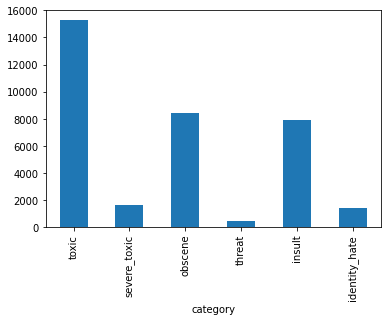

In [12]:
df_count.plot(kind='bar',x='category',y='number_of_comments',legend=False)

Text(0.5, 0, 'categories')

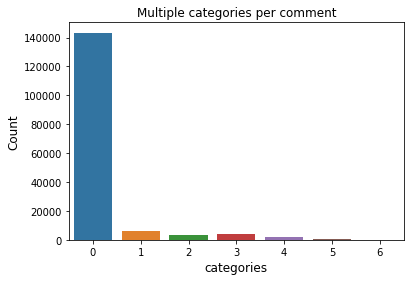

In [13]:
rowsums = df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('Count', fontsize=12)
plt.xlabel('categories', fontsize=12)

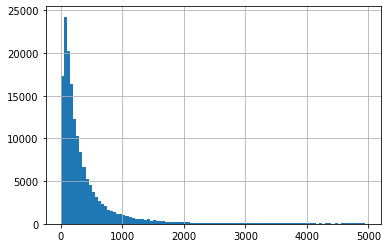

In [14]:
lens = df.comment_text.str.len()
lens.hist(bins = np.arange(0,5000,50))

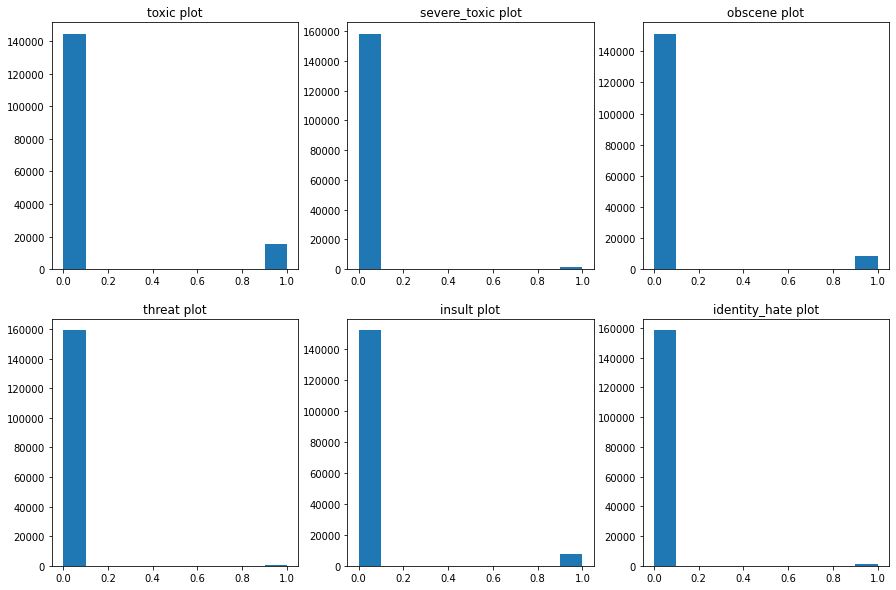

In [15]:
rows=2
cols=3
i=1

fig=plt.figure(figsize=(15,10))
for j in cat_cols:
  plt.subplot(rows,cols,i)
  plt.title('{} plot'.format(j,rows,cols,i))
  plt.xlabel('')
  plt.hist(df[j])
  i=i+1

In [16]:
values=[]
for i in cat_cols:
  values.append([i,df[df[i]==1].count()[0]])

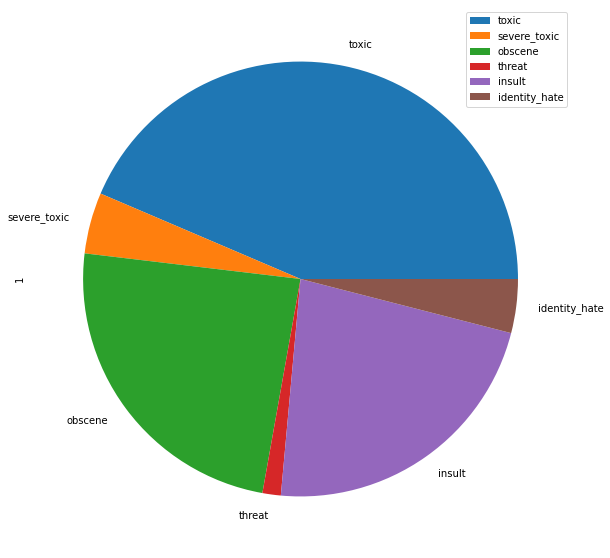

In [17]:
pd.DataFrame(values).set_index(0).plot.pie(y=1,figsize=(10,10))

In [18]:
df=df.drop(index=115606) # Causing problem

In [19]:
df['filtered_text']=df['comment_text'].apply(lambda x: rem_stop_words_with_stemming(x))

In [20]:
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,filtered_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explan edit made usernam hardcor metallica fan...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,d'aww ! match background colour 'm seemingli s...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"hey man , 'm realli tri edit war . 's guy cons..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,`` ca n't make real suggest improv - wonder se...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,", sir , hero . chanc rememb page 's ?"
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,"`` congratul well , use tool well . Â· talk ``"
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,cocksuck piss around work
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,vandal matt shirvington articl revert . pleas ...
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,"sorri word 'nonsens ' offens . anyway , 'm int..."
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,align subject contrari dulithgow


In [21]:
toxic="".join([i for i in df[df['toxic']==1]['comment_text']])
severe_toxic="".join([i for i in df[df['severe_toxic']==1]['comment_text']])
obscene="".join([i for i in df[df['obscene']==1]['comment_text']])
threat="".join([i for i in df[df['threat']==1]['comment_text']])
insult="".join([i for i in df[df['insult']==1]['comment_text']])
identity_hate="".join([i for i in df[df['identity_hate']==1]['comment_text']])

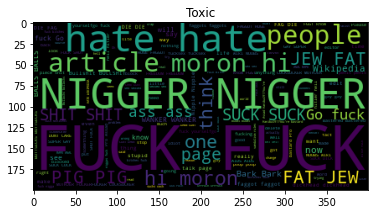

In [22]:
word_cloud=WordCloud(max_font_size=100).generate(toxic)
plt.imshow(word_cloud)
plt.title('Toxic')
plt.show()


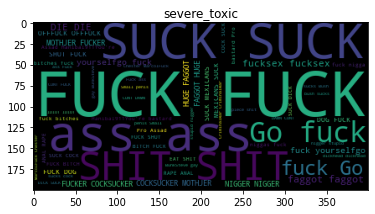

In [23]:
word_cloud=WordCloud(max_font_size=100).generate(severe_toxic)
plt.imshow(word_cloud)
plt.title('severe_toxic')
plt.show()


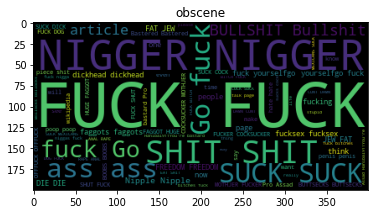

In [24]:
word_cloud=WordCloud(max_font_size=100).generate(obscene)
plt.imshow(word_cloud)
plt.title('obscene')
plt.show()


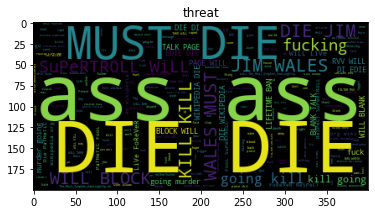

In [25]:
word_cloud=WordCloud(max_font_size=100).generate(threat)
plt.imshow(word_cloud)
plt.title('threat')
plt.show()


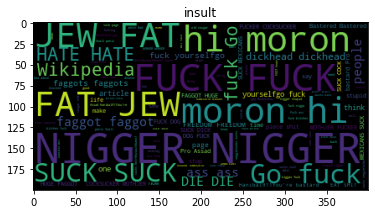

In [26]:
word_cloud=WordCloud(max_font_size=100).generate(insult)
plt.imshow(word_cloud)
plt.title('insult')
plt.show()


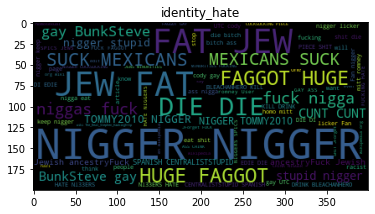

In [27]:
word_cloud=WordCloud(max_font_size=100).generate(identity_hate)
plt.imshow(word_cloud)
plt.title('identity_hate')
plt.show()


In [28]:
train_ratio = 0.80
test_ratio = 0.20
df_train,df_test = train_test_split(df, test_size=1 - train_ratio)

In [29]:
X_train=df_train.filtered_text
X_test=df_test.filtered_text

In [30]:
pipelines = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
for col in cat_cols:
    print('Processing {}'.format(col))
    pipelines.fit(X_train, df_train[col])
    prediction = pipelines.predict(X_test)
    print('Test f1_score: {}'.format(f1_score(df_test[col], prediction)))
    print('Test precision: {}'.format(precision_score(df_test[col], prediction)))
    print('Test recall: {}'.format(recall_score(df_test[col], prediction)))
    print('Test accuracy: {}'.format(accuracy_score(df_test[col], prediction)))
    print('Test auc_roc: {}'.format(roc_auc_score(df_test[col], prediction)))

Processing toxic
Test f1_score: 0.3003781739600216
Test precision: 0.9893238434163701
Test recall: 0.1770700636942675
Test accuracy: 0.9188443943097073
Test auc_roc: 0.5884307710561418
Processing severe_toxic
Test f1_score: 0.0
Test precision: 0.0
Test recall: 0.0
Test accuracy: 0.9899417183681143
Test auc_roc: 0.4999841742102931
Processing obscene
Test f1_score: 0.19876416065911431
Test precision: 0.9846938775510204
Test recall: 0.11053837342497136
Test accuracy: 0.9512439681644419
Test auc_roc: 0.5552194651532176
Processing threat
Test f1_score: 0.022988505747126436
Test precision: 1.0
Test recall: 0.011627906976744186
Test accuracy: 0.9973365920912453
Test auc_roc: 0.5058139534883721
Processing insult
Test f1_score: 0.0774818401937046
Test precision: 0.9142857142857143
Test recall: 0.040455120101137804
Test accuracy: 0.9522466629065613
Test auc_roc: 0.5201286546041757
Processing identity_hate
Test f1_score: 0.0
Test precision: 0.0
Test recall: 0.0
Test accuracy: 0.9910384157423074
T

In [31]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LinearSVC(class_weight="balanced"), n_jobs=2)),
            ])

for col in cat_cols:
    print('Processing {}'.format(col))
    SVC_pipeline.fit(X_train, df_train[col])
    prediction = SVC_pipeline.predict(X_test)
    print('Test f1_score: {}'.format(f1_score(df_test[col], prediction)))
    print('Test precision: {}'.format(precision_score(df_test[col], prediction)))
    print('Test recall: {}'.format(recall_score(df_test[col], prediction)))
    print('Test accuracy: {}'.format(accuracy_score(df_test[col], prediction)))
    print('Test auc_roc: {}'.format(roc_auc_score(df_test[col], prediction)))

Processing toxic
Test f1_score: 0.7448036951501156
Test precision: 0.6810982048574445
Test recall: 0.821656050955414
Test accuracy: 0.9446011154979006
Test auc_roc: 0.8898368528913443
Processing severe_toxic
Test f1_score: 0.4041237113402062
Test precision: 0.30153846153846153
Test recall: 0.6125
Test accuracy: 0.9818888262204675
Test auc_roc: 0.7990650914730645
Processing obscene
Test f1_score: 0.7814675950723086
Test precision: 0.7339034205231388
Test recall: 0.8356242840778924
Test accuracy: 0.9744312840759541
Test auc_roc: 0.9090445737546715
Processing threat
Test f1_score: 0.35680751173708924
Test precision: 0.2992125984251969
Test recall: 0.4418604651162791
Test accuracy: 0.9957072131353011
Test auc_roc: 0.7195320925556259
Processing insult
Test f1_score: 0.6643653744025492
Test precision: 0.5728021978021978
Test recall: 0.7907711757269279
Test accuracy: 0.9603935576862819
Test auc_roc: 0.8800057909493139
Processing identity_hate
Test f1_score: 0.4366576819407008
Test precision: 

In [32]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag',class_weight="balanced"), n_jobs=2)),
            ])

for col in cat_cols:
    print('Processing {}'.format(col))
    LogReg_pipeline.fit(X_train, df_train[col])
    prediction = LogReg_pipeline.predict(X_test)
    print('Test f1_score: {}'.format(f1_score(df_test[col], prediction)))
    print('Test precision: {}'.format(precision_score(df_test[col], prediction)))
    print('Test recall: {}'.format(recall_score(df_test[col], prediction)))
    print('Test accuracy: {}'.format(accuracy_score(df_test[col], prediction)))
    print('Test auc_roc: {}'.format(roc_auc_score(df_test[col], prediction)))

Processing toxic
Test f1_score: 0.73786941580756
Test precision: 0.649093107617896
Test recall: 0.8547770700636943
Test accuracy: 0.9402456602118192
Test auc_roc: 0.9021748004103138
Processing severe_toxic
Test f1_score: 0.24675324675324675
Test precision: 0.14321608040201006
Test recall: 0.890625
Test accuracy: 0.9454784733972551
Test auc_roc: 0.9183295285497246
Processing obscene
Test f1_score: 0.7826528024346945
Test precision: 0.7023213472917615
Test recall: 0.8837342497136311
Test accuracy: 0.9731465814376136
Test auc_roc: 0.93102782493637
Processing threat
Test f1_score: 0.04104582513353951
Test precision: 0.021031403053874964
Test recall: 0.8488372093023255
Test accuracy: 0.8931190073322053
Test auc_roc: 0.8710379335439616
Processing insult
Test f1_score: 0.642083429361604
Test precision: 0.505259339862169
Test recall: 0.8805309734513275
Test accuracy: 0.9513379707965156
Test auc_roc: 0.9177809819122654
Processing identity_hate
Test f1_score: 0.2054728756601056
Test precision: 0

## OnevsAll using LSTM


In [43]:
token = Tokenizer()
token.fit_on_texts(df["filtered_text"])

In [44]:
vocab_size=len(token.word_index)+1
vocab_size

165843

In [68]:
enc_text=token.texts_to_sequences(df["filtered_text"])

In [46]:
MAX_LEN=250
X=pad_sequences(enc_text,maxlen=MAX_LEN,padding="post")

In [56]:
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15
emb_dim=300
epochs=5

In [67]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec


In [100]:
w2v=Word2Vec([i.split() for i in df['filtered_text']],size=emb_dim)

In [108]:
w2v.most_similar('oop')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('whoop', 0.8050834536552429),
 ('Ah', 0.7702125310897827),
 ('hehe', 0.7610569000244141),
 ('Uh', 0.7515493035316467),
 ('Ha', 0.7411371469497681),
 ('ugh', 0.7340079545974731),
 ('haha', 0.7302718162536621),
 ('yep', 0.7232915759086609),
 ('nevermind', 0.7178897261619568),
 ('ooop', 0.7172434329986572)]

In [109]:
w2v.wv.get_keras_embedding(train_embeddings=False)

In [111]:
model=tf.keras.models.Sequential([
                                  tf.keras.layers.Input((MAX_LEN,)),
                                  w2v.wv.get_keras_embedding(train_embeddings=False),
                                  # Embedding(vocab_size,emb_dim),
                                  LSTM(512,return_sequences=True),
                                  BatchNormalization(),
                                  Dropout(0.2),
                                  LSTM(256,return_sequences=True),
                                  BatchNormalization(),
                                  Dropout(0.2),
                                  LSTM(128,return_sequences=True),
                                  BatchNormalization(),
                                  Dropout(0.2),
                                  LSTM(64,return_sequences=True),
                                  tf.keras.layers.GlobalAveragePooling1D(),
                                  
                                  Dense(64,activation='relu'),

                                  Dense(32,activation='relu'),

                                  Dense(16,activation='relu'),

                                  Dense(1,activation="sigmoid")
])

In [114]:
for col in cat_cols:
  print("Training {} columns".format(i))
  y=df[col]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio,stratify=y)
  X_val, X_test, y_val, y_test = train_test_split(X_test, y_test,stratify=y_test,test_size=test_ratio/(test_ratio + validation_ratio)) 
  print('X_train shape :', X_train.shape,'X_val shape :', X_val.shape, 'X_test shape: ',X_test.shape)
  model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy",'Precision','Recall','AUC'])
  path="/content/trained_model/{}.hd5".format(col)
  checkpoint=ModelCheckpoint(path,monitor="val_loss",mode="min",save_best_only=True,verbose=1)
  earlystop=EarlyStopping(monitor="val_loss",min_delta=0,patience=6,verbose=1,restore_best_weights=True)
  reduce_lr=ReduceLROnPlateau(monitor="val_loss",factor=0.2,patience=2,verbose=1,min_delta=0.0001)
  callbacks=[checkpoint,earlystop,reduce_lr]
  class_weights = class_weight.compute_class_weight('balanced',[0,1],df[col])
  class_weight_dict = dict(enumerate(class_weights))
  print(class_weight_dict)
  history=model.fit(X_train,y_train,class_weight=class_weight_dict,
                              epochs=epochs,callbacks=callbacks,
                              validation_data=(X_val,y_val)
                              )
  pd.DataFrame(history.history).plot()





Training identity_hate columns
X_train shape : (111698, 250) X_val shape : (23936, 250) X_test shape:  (23936, 250)
{0: 0.5530025783914164, 1: 5.216751667320517}
Epoch 1/5
3491/3491 [==============================] - 1097s 312ms/step - loss: 0.3400 - accuracy: 0.8707 - precision: 0.4119 - recall: 0.8168 - auc: 0.9268 - val_loss: 0.2562 - val_accuracy: 0.9078 - val_precision: 0.5122 - val_recall: 0.7977 - val_auc: 0.9413

Epoch 00001: val_loss improved from inf to 0.25616, saving model to /content/trained_model/toxic.hd5


Epoch 2/5
3491/3491 [==============================] - 1076s 308ms/step - loss: 0.2748 - accuracy: 0.8878 - precision: 0.4556 - recall: 0.8761 - auc: 0.9534 - val_loss: 0.1855 - val_accuracy: 0.9301 - val_precision: 0.6059 - val_recall: 0.7755 - val_auc: 0.9442

Epoch 00002: val_loss improved from 0.25616 to 0.18548, saving model to /content/trained_model/toxic.hd5


Epoch 3/5
1011/3491 [=======>......................] - ETA: 11:54 - loss: 0.2363 - accuracy: 0.9076 - precision: 0.5055 - recall: 0.8921 - auc: 0.9652

KeyboardInterrupt: ignored

In [ ]:
y = df[cat_cols]

In [ ]:
X.shape,y.shape

((159570, 250), (159570, 6))

In [ ]:
NUM_WORDS=60000
MAXLEN=200
(X_train, y_train), (X_val, y_val), preproc = text.texts_from_df(train_df=df_train,
                                                                   text_column = 'filtered_text',
                                                                   label_columns = cat_cols,
                                                                   maxlen = MAXLEN,
                                                                   ngram_range=2,
                                                                   max_features=NUM_WORDS)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
        toxic  severe_toxic  obscene  threat  insult  identity_hate
117916      0             0        0       0       0              0
23206       1             0        0       0       0              0
131130      0             0        0       0       0              0
51160       0             0        0       0       0              0
139837      0             0        0       0       0              0
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
        toxic  severe_toxic  obscene  threat  insult  identity_hate
16558       0             0        0       0       0              0
16643       0             0        0       0       0              0
2157        0             0        0       0       0              0
152810      0             0        0       0       0              0
26445       0             0        0       0       0              0
language: en
Word Counts: 139693
Nro

In [ ]:
# NUM_WORDS=50000
# MAXLEN=150
# train,val,preproc=text.texts_from_csv("/content/train.csv",'comment_text',label_columns=cat_cols,ngram_range=2,max_features=NUM_WORDS,maxlen=MAXLEN)
# # use different value of ngram

In [ ]:
text.print_text_classifiers() # In accuracy BERT will outperform, but for real time faster response is achieved by fast text

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) from keras_bert [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face transformers [https://arxiv.org/abs/1910.01108]


In [ ]:
model=text.text_classifier('fasttext',(X_train,y_train),preproc)

Is Multi-Label? True
compiling word ID features...
maxlen is 200
done.


In [ ]:
learner=ktrain.get_learner(model,(X_train,y_train),(X_val, y_val))

In [ ]:
learner.autofit(5e-4,3)



begin training using triangular learning rate policy with max lr of 0.0005...
Epoch 1/3
3815/3815 [==============================] - 407s 106ms/step - loss: 0.1990 - accuracy: 0.5369 - val_loss: 0.0631 - val_accuracy: 0.9934
Epoch 2/3
3815/3815 [==============================] - 404s 106ms/step - loss: 0.0769 - accuracy: 0.9367 - val_loss: 0.0570 - val_accuracy: 0.9934
Epoch 3/3
3815/3815 [==============================] - 402s 105ms/step - loss: 0.0644 - accuracy: 0.9882 - val_loss: 0.0547 - val_accuracy: 0.9934


In [ ]:
pred=ktrain.get_predictor(learner.model,preproc)

In [ ]:
df_test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,filtered_text
28444,4b4e9af546f76f5e,"However, you removed edits by another user reg...",0,0,0,0,0,0,"howev , remov edit anoth user regard felt opin..."
123294,9382bcf314503bdc,"""\nClearly you are misunderstanding my replies...",0,0,0,0,0,0,`` clearli misunderstand repli . vote neutral ...
756,0207005a6576eafc,"Here's an idea \n\nGo fuck yourself, cumshitter.",1,1,1,0,1,0,"'s idea Go fuck , cumshitt ."
151282,7a8287d19c7617a5,"""\n\n Major expansion \n\nI'm going to try to ...",0,0,0,0,0,0,`` major expans 'm go tri expand list greatli ...
4671,0c5eb26205c4aa49,Penis \n\nDid you sex with Grawp? H-A-6-6-E-P?...,1,0,1,0,0,0,peni sex grawp ? h-a-6-6-e-p ? ? ? peni . peni...


In [ ]:
y_pred_probs=pred.predict_proba(list(df_test['filtered_text']))

In [ ]:
threshold=0.5
y_pred=np.array([1 if j>threshold else 0 for i in y_pred_probs for j in i]).reshape(len(df_test),6)

In [ ]:
y_pred

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
y_test=df_test.iloc[:,2:-1].values

In [ ]:
y_test

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0]])

In [ ]:
len(y_pred)

23936

## Metrics for evaluation


### Exact match ratio
* One trivial way around would just to ignore partially correct (consider them incorrect) and extend the accuracy used in single label case for multi-label prediction.where I is the indicator function. Clearly, a disadvantage of this measure is that it does not distinguish between complete incorrect and partially correct which might be considered harsh.

\begin{equation}
\text{Exact Match Ratio, MR} = \frac{1}{n} \sum_{i=1}^{n} I(y_{i} = \hat{y_{i}})
\end{equation}

In [ ]:
MR = np.all(y_pred == y_test, axis=1).mean() # Exact match ratio MR=1nâˆ‘i=1nI(yi=yi^)
print(MR)

0.9169034090909091


###  0/1 Loss

This metric is basically known as 1âˆ’Exact Match Ratio, where we calculate proportions of instances whose actual value is not equal to predicted value.

\begin{equation}
\text{0/1 Loss} = \frac{1}{n} \sum_{i=1}^{n} I\left(y_{i} \neq \hat{y_{i}} \right)
\end{equation}

In [ ]:
np.any(y_test != y_pred, axis=1).mean()

0.08309659090909091

###  Accuracy

Accuracy for each instance is defined as the proportion of the predicted correct labels to the total number (predicted and actual) of labels for that instance. Overall accuracy is the average across all instances. It is less ambiguously referred to as the Hamming score.
\begin{equation}
\text{Accuracy} = \frac{1}{n} \sum_{i=1}^{n} \frac{\lvert y_{i} \cap \hat{y_{i}}\rvert}{\lvert y_{i} \cup \hat{y_{i}}\rvert}
\end{equation}

In [ ]:
  def Accuracy(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        temp += sum(np.logical_and(y_test[1],y_pred[1]))/sum(np.logical_or(y_test[1],y_pred[1]))
    return temp / y_true.shape[0]
    
  Accuracy(y_test, y_pred_probs)

0.0

In [ ]:
  def Hamming_Loss(y_true, y_pred):
    temp=0
    for i in range(y_true.shape[0]):
        temp += np.size(y_true[i] == y_pred[i]) - np.count_nonzero(y_true[i] == y_pred[i])
    return temp/(y_true.shape[0] * y_true.shape[1])
    
  Hamming_Loss(y_test, y_pred)

0.02017184714795009

In [ ]:
  def Precision(y_true, y_pred):
      temp = 0
      for i in range(y_true.shape[0]):
          if sum(y_true[i]) == 0:
              continue
          temp+= sum(np.logical_and(y_true[i], y_pred[i]))/ sum(y_true[i])
      return temp/ y_true.shape[0]

Precision(y_test,y_pred)

0.05646097927807484

In [ ]:
def Recall(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        if sum(y_pred[i]) == 0:
            continue
        temp+= sum(np.logical_and(y_true[i], y_pred[i]))/ sum(y_pred[i])
    return temp/ y_true.shape[0]
Recall(y_test,y_pred)
  

0.0555021724598931

In [ ]:
def F1Measure(y_true, y_pred):
  temp = 0
  for i in range(y_true.shape[0]):
      if (sum(y_true[i]) == 0) and (sum(y_pred[i]) == 0):
          continue
      temp+= (2*sum(np.logical_and(y_true[i], y_pred[i])))/ (sum(y_true[i])+sum(y_pred[i]))
  return temp/ y_true.shape[0]
  
print(F1Measure(y_test, y_pred))

0.05331349869493247


In [ ]:
x="Bruh.. Is this working? You're trash, This thing doesn't work, You are pretty bad at this. Get a life kid."
pred.predict_proba([rem_stop_words_with_stemming(x)])

array([[0.6361023 , 0.06792081, 0.31931248, 0.04592843, 0.38614914,
        0.14808352]], dtype=float32)

In [ ]:
x="Bruh.. Is this working? You're trash, This thing doesn't work, You are pretty bad at this. Get a life kid."
pred.predict([rem_stop_words_with_stemming(x)])

[[('toxic', 0.6361023),
  ('severe_toxic', 0.06792081),
  ('obscene', 0.31931248),
  ('threat', 0.045928426),
  ('insult', 0.38614914),
  ('identity_hate', 0.14808352)]]

In [ ]:
pred.save('/content/fasttext')

In [ ]:
!zip -r /content/drive/MyDrive/Unlimited/Datasets/MultiLabelTextSegmentation/fasttext.zip /content/fasttext

  adding: content/fasttext/ (stored 0%)
  adding: content/fasttext/tf_model.preproc (deflated 47%)
  adding: content/fasttext/tf_model.h5
 (deflated 68%)


In [ ]:
# df_new=pd.read_csv('/content/test.csv')
# df_new.head()

In [ ]:
!zip -r /content/fasttext.zip /content/fasttext

  adding: content/fasttext/ (stored 0%)
  adding: content/fasttext/tf_model.preproc (deflated 47%)
  adding: content/fasttext/tf_model.h5 (deflated 68%)
